# Fundamentals of Machine Learning: Project 1

## Bernardo Costa, Fábio Almeida, Ivo Rodrigues

**Objectives**: Implement an ANN model and see if it works on step detection.

**Problem:** Build an ANN model to predict whether the smartphone accelerometer data corresponds to a real step or not. For this, the mobile phone should be held in a texting position.

In [120]:
#Import relevant libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat
import random as rd
from IPython.display import clear_output, display
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score

### Loading and restructuring smartphone data: training set

In [121]:
# file imports
training_raw_acc = pd.read_csv("Training/TrainingAccZAxis.txt",header=None)
training_raw_dif = pd.read_csv("Training/TrainingDiffs.txt",header=None)
training_raw_stp = pd.read_csv("Training/TrainingStepsOrNot.txt",header=None)

# initial data structures
aux_xtrain_acc = training_raw_acc.values
aux_xtrain_dif = training_raw_dif.values
aux_ytrain = training_raw_stp.values

# size validation of imported data
n_xtrain_acc = len(aux_xtrain_acc)
n_xtrain_dif = len(aux_xtrain_dif)
n_ytrain = len(aux_ytrain)

if ((n_xtrain_acc != n_ytrain) or (n_xtrain_dif != n_ytrain)):
    print("IMPORTED ARRAYS HAVE DIFFERENT LENGTHS!")

### restructuring data into features and corresponding labels ###

window_size = 3 # window size must be positive and odd
if ((window_size % 2 == 0) or (window_size <= 0)):
    print("INVALID WINDOW SIZE! AUTOMATICALLY DECREMENTING 1 FROM THE SET VALUE FOR VALID EXECUTION")
    window_size -= 1
    
p = int((window_size-1)/2) # defines both window center and number of past/future samples to be evaluated

l = p # l is the control variable for the while loop below

# feature array initialization
matrix_m = n_xtrain_acc - 2*p;

Xtrain_acc = np.zeros((matrix_m,window_size))
Xtrain_dif = np.zeros((matrix_m,window_size))
ytrain = np.zeros((matrix_m,1))

aux_xtrain_acc = aux_xtrain_acc.reshape(1,len(aux_xtrain_acc))
aux_xtrain_dif = aux_xtrain_dif.reshape(1,len(aux_xtrain_dif))
aux_ytrain = aux_ytrain.reshape(len(aux_ytrain),1)

# filling the feature array
while(l <= n_xtrain_acc - p - 1):
    Xtrain_acc[l-p][:] = aux_xtrain_acc[0,(l-p):(l+p+1)]
    Xtrain_dif[l-p][:] = aux_xtrain_dif[0,(l-p):(l+p+1)]
    if(aux_ytrain[l,0] == 1):
        ytrain[l-p,0] = int(1)
    else:
        ytrain[l-p,0] = int(0)
    l += 1

Xtrain = np.concatenate((Xtrain_acc, Xtrain_dif), axis=1)

# update window size after concatenate
window_size = Xtrain.shape[1]
print("Step window size:", window_size)

### Balancing data: discarding some 'zero' examples ###
ones_examples = int(sum(ytrain))
total_zeros = len(ytrain) - ones_examples

k = 0
k2 = 0
arr_zer_index = np.zeros((total_zeros,1))

while(k < len(ytrain)):
    if ytrain[k] == 0:
        arr_zer_index[k2] = k
        k2 += 1
    k += 1
    
indexes = rd.sample(range(len(arr_zer_index)), ones_examples) # return random array indexes

# return original ones separately
aux_ones_X = np.zeros((ones_examples,window_size))
aux_ones_y = np.zeros((ones_examples,1))

k = 0
k2 = 0

while(k < len(ytrain)):
    if ytrain[k] == 1:
        aux_ones_X[k2,:] = Xtrain[k]
        aux_ones_y[k2] = ytrain[k]
        k2 += 1
    k += 1
    
# return original zeros separately
aux_zrs_X = np.zeros((total_zeros,window_size))
aux_zrs_y = np.zeros((total_zeros,1))

k = 0
k2 = 0

while(k < len(ytrain)):
    if ytrain[k] == 0:
        aux_zrs_X[k2,:] = Xtrain[k]
        aux_zrs_y[k2] = ytrain[k]
        k2 += 1
    k += 1
    
# Get corresponding zeros from indexes

k = 0
new_zeros_X = np.zeros((ones_examples,window_size))
new_zeros_y = np.zeros((ones_examples,1))

while(k < len(indexes)):
    new_zeros_X[k,:] = aux_zrs_X[indexes[k]]
    new_zeros_y[k] = aux_zrs_y[indexes[k]]
    k += 1
    
# Xtrain = np.concatenate((aux_ones_X, new_zeros_X), axis=0)
# ytrain = np.concatenate((aux_ones_y, new_zeros_y), axis=0)

X = np.concatenate((aux_ones_X, new_zeros_X), axis=0)
y = np.concatenate((aux_ones_y, new_zeros_y), axis=0)

m = len(y)

with open('TRAINING_matrixy.txt', 'w') as testfile:
    for row in y:
        testfile.write(' '.join([str(int(a)) for a in row]) + '\n')


with open('TRAINING_matrixX.txt', 'w') as testfile:
    for row in X:
        testfile.write(' '.join([str(a) for a in row]) + '\n')
        

if (len(Xtrain) != len(ytrain)) :
    print("SOMETHING WENT WRONG DURING DATA RESTRUCTURING!")
else:
    print("'Phase 1: Importing and restructuring training data' successfuly completed.")
    
print("X shape =",X.shape)
print("Y shape =",y.shape)

### end of data restructuring ###

Step window size: 6
'Phase 1: Importing and restructuring training data' successfuly completed.
X shape = (6000, 6)
Y shape = (6000, 1)


## Random sorting array values for k-folds CV
At this point, all 1s and 0s are grouped together. Arrays should be re-sorted.
A new cross-validation set should be created.

In [122]:
aux_trainData = np.concatenate((X, y), axis=1)
np.random.shuffle(aux_trainData) # array is resorted
X_len = X.shape[0]
X_col = window_size
y_col = y.shape[1]
X = aux_trainData[:,:window_size].copy()
y = aux_trainData[:,window_size].copy()
y = np.reshape(y, (-1, 1))
print(X.shape)
print(y.shape)

with open('sortedTRAINING_matrixy.txt', 'w') as testfile:
    for row in y:
        testfile.write(' '.join([str(int(a)) for a in row]) + '\n')
        
with open('sortedTRAINING_matrixX.txt', 'w') as testfile:
    for row in X:
        testfile.write(' '.join([str(a) for a in row]) + '\n')

(6000, 6)
(6000, 1)


### Sigmoid Function

In [123]:
# Add sigmoid FUNCTION from the previous lab
def sigmoid(z):
    """
    return the sigmoid of z
    """

    gz=1/(1+np.exp(-z))
    
    return gz

### Sigmoid Gradient

In [124]:
#Computes the gradient of sigmoid function
def sigmoid_Gradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

### Leaky ReLU function

In [125]:
def leaky_ReLU(x,c):
    data = [np.maximum(c*value,value) for value in x]
    return np.array(data, dtype=float)

### Leaky ReLU gradient

In [126]:
def leaky_ReLU_Gradient(x,c):
    data = [1 if value>0 else c for value in x]
    return np.array(data, dtype=float)

### Function to initialize the weights of the layers

In [127]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

### Cost Function

In [128]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    mse = 0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = leaky_ReLU(X @ Theta1.T,0.1)
    #a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
        mse = mse + sum((a2[:,j] - y10[:,j])**2)
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    e_theta = mse/(2*m)
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * leaky_ReLU_Gradient(np.hstack((1,xi @ Theta1.T)),0.1)
        #d1 = Theta2.T @ d2.T * sigmoid_Gradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg, e_theta

### Gradient Descent

In [129]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels,kfolditer):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    percent=1
    plt.xlabel("Iteration")
    plt.ylabel("$J(\Theta)$")
    plt.title("Cost function using Gradient Descent")
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2,reg_J, grad1_reg, grad2_reg, e_theta = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)
        Theta1 = Theta1 - (alpha * grad1_reg)
        Theta2 = Theta2 - (alpha * grad2_reg)
        J_history.append(reg_J)
        
        if int(100/num_iters*i)==percent:
            clear_output(wait=True)
            if(kfolditer > 0):
                print("Iteration", kfolditer, ":", percent," % completed")
            else:
                print(percent," % completed")
            percent+=1        
            plt.plot(J_history)
            display(plt.gcf())
            
    sys.stdout.flush()
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history, e_theta

### Prediction Function

In [130]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    
    #number of training examples
    m= X.shape[0]
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m,1)),X,axis=1)
    Theta1 = np.transpose(Theta1)
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1= np.dot(X, Theta1)  #Inputs to the hidden layer neurons
    a1= leaky_ReLU(z1,0.1)  #Outputs  of the hidden layer neurons
    #a1= sigmoid(z1)  #Outputs  of the hidden layer neurons
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)),a1,axis=1)
    Theta2 = np.transpose(Theta2)
    #Compute the output of the output layer (with sigmoid activation functions)
    z2= np.dot(a1, Theta2)  #Inputs to the output layer neurons
    a2= sigmoid(z2)  #Outputs  of the output layer neurons
    
    return a2

## Training the model
### The best $ \lambda $ is determined through the K-folds CV method

Iteration 1 : 1  % completed


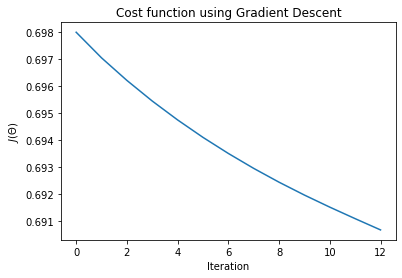

KeyboardInterrupt: 

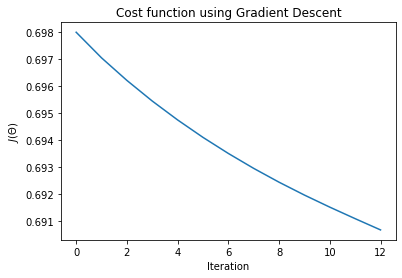

In [113]:
input_layer_size  = 6    # number of features of input layer
hidden_layer_size = 3    # number of features of hidden layer
num_labels = 1           # number of features of output layer
alpha=0.2                # learning rate
num_iters=1200            # number of iterations

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

#Implementing cross validation

k = 5
counter = 0
kf = KFold(n_splits=k, random_state=None)
#Lambdas = np.array([0,0.01,0.1,1])
Lambdas = np.array([0, 0.01, 0.1, 1])
acc_score = []
err_temp = 0
err_total = np.zeros((len(Lambdas),1))
 
for train_index , test_index in kf.split(X):
    counter += 1
    
    error_vec = []
    
    kX_train , kX_test = X[train_index,:],X[test_index,:]
    ky_train , ky_test = y[train_index] , y[test_index]
    
    for i in range (len(Lambdas)):
    
        nnTheta, nnJ_history, err_temp = gradientDescentnn(kX_train,ky_train,initial_nn_params,alpha,num_iters,Lambdas[i],input_layer_size, hidden_layer_size, num_labels,counter)
        err_total[i] = err_total[i] + err_temp
        Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
        Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
        
    '''err_total[0] = err_total[0] + error_vec[0]
    err_total[1] = err_total[1] + error_vec[1]
    err_total[2] = err_total[2] + error_vec[2]
    err_total[3] = err_total[3] + error_vec[3]'''
    
    #pred3 = predict(Theta1, Theta2, kX_test)
    #new_pred = np.zeros((len(pred3),1))

    '''for i in range(len(pred3)):
        if(pred3[i,0])>0.5:
            new_pred[i,0]=1    '''
     
    #acc = accuracy_score(new_pred , ky_test)
    #acc_score.append(acc)

err_total = err_total/4
lambda_index = np.argmin(err_total)
#avg_acc_score = sum(acc_score)/k
 
#print('Accuracy of each fold - {}'.format(acc_score))
#print('Average accuracy : {}'.format(avg_acc_score))
print(err_total)
print("The best lambda is: ",Lambdas[lambda_index])


### Now, training the model with the original training set, using the best hyperparameter $ \lambda $


99  % completed


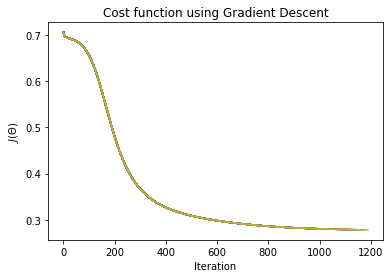

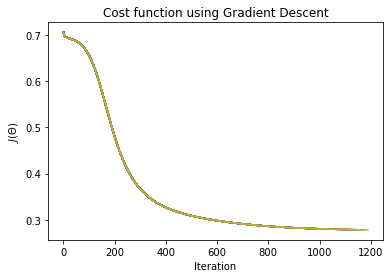

In [131]:
best_lambda = 0

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

nnTheta, nnJ_history, e_theta = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,best_lambda,input_layer_size, hidden_layer_size, num_labels,0)
Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)



In [134]:
tmp_pred = predict(Theta1, Theta2, X)

train_pred = np.zeros((len(tmp_pred),1))

final_train_pred = np.zeros((len(tmp_pred),1))

limiar = 0
best_limiar = 0
temp = 0

max_accuracy = 0

while (limiar < 1):    
    train_pred = np.zeros((len(tmp_pred),1))
    for j in range(len(tmp_pred)):
        if(tmp_pred[j,0])>limiar:
            train_pred[j,0]=1
    
    
    temp = 100*(sum(train_pred==y)[0])/len(y)
    
    if (temp > max_accuracy):
        max_accuracy = temp    
        best_limiar = limiar
        final_train_pred = train_pred
    limiar += 0.01
    
print("Best threshold is " , best_limiar, "with an accuracy of", max_accuracy)

Best threshold is  0.45000000000000023 with an accuracy of 89.76666666666667


### Confusion matrix for the training set

In [135]:
k=0
undetected_steps = 0
correct_steps = 0
correct_nonsteps = 0
fake_steps = 0
total_steps = int(sum(y))

while (k < len(y)):
    if (y[k] == 1):
        if(final_train_pred[k] == 1):
            correct_steps += 1
        else:
            undetected_steps +=1
        
    else:
        if(final_train_pred[k] == 1):
            fake_steps += 1
        else:
            correct_nonsteps += 1
    k += 1
    
print("Correct steps:", int(correct_steps))
print("Correct non-steps:", correct_nonsteps)
print("Fake steps:", int(fake_steps)) # should consider 1/3 second turn-off after step detection
print("Undetected steps:", int(np.ceil(undetected_steps)))
print("Total real steps:", total_steps)

Correct steps: 2673
Correct non-steps: 2713
Fake steps: 287
Undetected steps: 327
Total real steps: 3000


## Loading and restructuring smartphone data: testing set

In [136]:
# file imports
testing_raw_acc = pd.read_csv("Testing\TestingAccZAxis.txt",header=None)
testing_raw_dif = pd.read_csv("Testing\TestingDiffs.txt",header=None)
testing_raw_stp = pd.read_csv("Testing\TestingStepsOrNot.txt",header=None)

# initial data structures
aux_xtest_acc = testing_raw_acc.values
aux_xtest_dif = testing_raw_dif.values
aux_ytest = testing_raw_stp.values

# size validation of imported data
n_xtest_acc = len(aux_xtest_acc)
n_xtest_dif = len(aux_xtest_dif)
n_ytest = len(aux_ytest)

if ((n_xtest_acc != n_ytest) or (n_xtest_dif != n_ytest)):
    print("IMPORTED ARRAYS HAVE DIFFERENT LENGTHS!")

### restructuring data into features and corresponding labels ###

window_size = 3 # window size must be positive and odd
if ((window_size % 2 == 0) or (window_size <= 0)):
    print("INVALID WINDOW SIZE! AUTOMATICALLY DECREMENTING 1 FROM THE SET VALUE FOR VALID EXECUTION")
    window_size -= 1
    
p = int((window_size-1)/2) # defines both window center and number of past/future samples to be evaluated

l = p # l is the control variable for the while loop below

# feature array initialization
matrix_m = n_xtest_acc - 2*p;

Xtest_acc = np.zeros((matrix_m,window_size))
Xtest_dif = np.zeros((matrix_m,window_size))
ytest = np.zeros((matrix_m,1))

aux_xtest_acc = aux_xtest_acc.reshape(1,len(aux_xtest_acc))
aux_xtest_dif = aux_xtest_dif.reshape(1,len(aux_xtest_dif))
aux_ytest = aux_ytest.reshape(len(aux_ytest),1)

# filling the feature array
while(l <= n_xtest_acc - p - 1):
    Xtest_acc[l-p][:] = aux_xtest_acc[0,(l-p):(l+p+1)]
    Xtest_dif[l-p][:] = aux_xtest_dif[0,(l-p):(l+p+1)]
    if(aux_ytest[l,0] == 1):
        ytest[l-p,0] = int(1)
    else:
        ytest[l-p,0] = int(0)
    l += 1

Xtest = np.concatenate((Xtest_acc, Xtest_dif), axis=1)

# update window size after concatenate
window_size = Xtest.shape[1]
print("Step window size:", window_size)

### Balancing data: discarding some 'zero' examples ###
ones_examples = int(sum(ytest))
total_zeros = len(ytest) - ones_examples

k = 0
k2 = 0
arr_zer_index = np.zeros((total_zeros,1))

while(k < len(ytest)):
    if ytest[k] == 0:
        arr_zer_index[k2] = k
        k2 += 1
    k += 1
    
indexes = rd.sample(range(len(arr_zer_index)), ones_examples) # return random array indexes

# return original ones separately
aux_ones_X = np.zeros((ones_examples,window_size))
aux_ones_y = np.zeros((ones_examples,1))

k = 0
k2 = 0

while(k < len(ytest)):
    if ytest[k] == 1:
        aux_ones_X[k2,:] = Xtest[k]
        aux_ones_y[k2] = ytest[k]
        k2 += 1
    k += 1
    
# return original zeros separately
aux_zrs_X = np.zeros((total_zeros,window_size))
aux_zrs_y = np.zeros((total_zeros,1))

k = 0
k2 = 0

while(k < len(ytest)):
    if ytest[k] == 0:
        aux_zrs_X[k2,:] = Xtest[k]
        aux_zrs_y[k2] = ytest[k]
        k2 += 1
    k += 1
    
# Get corresponding zeros from indexes

k = 0
new_zeros_X = np.zeros((ones_examples,window_size))
new_zeros_y = np.zeros((ones_examples,1))

while(k < len(indexes)):
    new_zeros_X[k,:] = aux_zrs_X[indexes[k]]
    new_zeros_y[k] = aux_zrs_y[indexes[k]]
    k += 1

Xtest = np.concatenate((aux_ones_X, new_zeros_X), axis=0)
ytest = np.concatenate((aux_ones_y, new_zeros_y), axis=0)

with open('TESTING_matrixy.txt', 'w') as testfile:
    for row in ytest:
        testfile.write(' '.join([str(int(a)) for a in row]) + '\n')


with open('TESTING_matrixX.txt', 'w') as testfile:
    for row in Xtest:
        testfile.write(' '.join([str(a) for a in row]) + '\n')
        

if (len(Xtest) != len(ytest)) :
    print("SOMETHING WENT WRONG DURING DATA RESTRUCTURING!")
else:
    print("'Phase 2: Importing and restructuring testing data' successfuly completed.")
    
print("X shape =",Xtest.shape)
print("Y shape =",ytest.shape)

### end of data restructuring ###

Step window size: 6
'Phase 2: Importing and restructuring testing data' successfuly completed.
X shape = (1200, 6)
Y shape = (1200, 1)


### Testing the optimized model with the testing set

In [137]:
tmp_pred = predict(Theta1, Theta2, Xtest)

test_pred = np.zeros((len(tmp_pred),1))

final_test_pred = np.zeros((len(tmp_pred),1))

limiar = 0
best_limiar = 0
temp = 0

max_accuracy = 0

while (limiar < 1):    
    test_pred = np.zeros((len(tmp_pred),1))
    for j in range(len(tmp_pred)):
        if(tmp_pred[j,0])>limiar:
            test_pred[j,0]=1
    
    
    temp = 100*(sum(test_pred==ytest)[0])/len(ytest)
    
    if (temp > max_accuracy):
        max_accuracy = temp    
        best_limiar = limiar
        final_test_pred = test_pred
    limiar += 0.01
    
print("Best threshold is " , best_limiar, "with an accuracy of", max_accuracy)

Best threshold is  0.7200000000000004 with an accuracy of 88.41666666666667


### Confusion matrix for the testing set

In [138]:
k=0
undetected_steps = 0
correct_steps = 0
correct_nonsteps = 0
fake_steps = 0
total_steps = int(sum(ytest))

while (k < len(ytest)):
    if (ytest[k] == 1):
        if(final_test_pred[k] == 1):
            correct_steps += 1
        else:
            undetected_steps +=1        
    else:
        if(final_test_pred[k] == 1):
            fake_steps += 1
        else:
            correct_nonsteps += 1
    k += 1
    
print("Correct steps:", int(correct_steps))
print("Correct non-steps:", correct_nonsteps)
print("Fake steps:", int(fake_steps)) # should consider 1/3 second turn-off after step detection
print("Undetected steps:", int(np.ceil(undetected_steps)))
print("Total real steps:", total_steps)

Correct steps: 513
Correct non-steps: 548
Fake steps: 52
Undetected steps: 87
Total real steps: 600
